In [1]:
import pandas as pd
from datasets import Dataset
import matplotlib.pyplot as plt
from transformers import AutoTokenizer,Trainer, TrainingArguments,AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, f1_score

In [2]:
train_df = pd.read_csv("../data/train.csv")
valid_df = pd.read_csv("../data/valid.csv")
train_df.head()

,Unnamed: 0,text,label
0,78023,Greatest Jeff Bridges movie ever. I absolutely...,0
1,419388,"Rarely, very rarely, I give such high rating o...",0
2,557333,"I must say, dang, I underrated this film immen...",0
3,451866,If I ever got together with a group of my frie...,0
4,190239,"In theory, a thriller about magic should be a ...",0


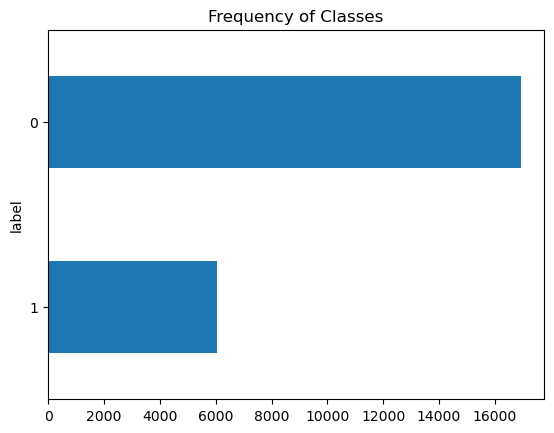

In [3]:
train_df["label"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

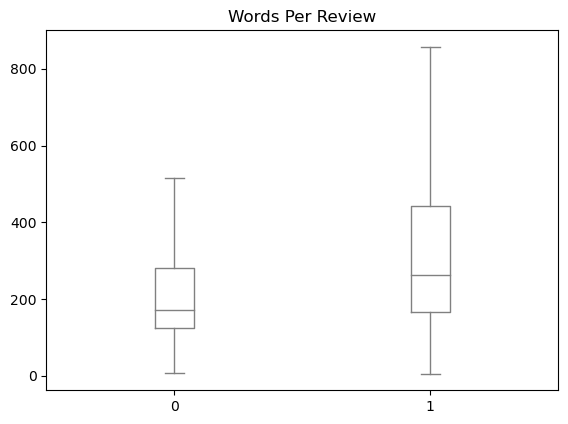

In [4]:
train_df["Words Per Review"] = train_df["text"].str.split().apply(len)
train_df.boxplot("Words Per Review", by="label", grid=False, showfliers=False,
           color="gray")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [5]:
train_df.drop(['Words Per Review'], axis=1, inplace=True)

In [6]:
train_ds = Dataset.from_pandas(train_df)
valid_ds = Dataset.from_pandas(valid_df)
train_ds,valid_ds

(Dataset({
     features: ['Unnamed: 0', 'text', 'label'],
     num_rows: 22956
 }),
 Dataset({
     features: ['Unnamed: 0', 'text', 'label'],
     num_rows: 5740
 }))

In [7]:
model_ckpt = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [8]:
encoded_text = tokenizer(train_df["text"][0])
encoded_text

{'input_ids': [0, 19065, 990, 2321, 18765, 1569, 655, 4, 38, 3668, 2638, 42, 822, 4, 85, 34, 960, 35, 9117, 6, 2196, 6, 39428, 6, 627, 2543, 6, 642, 4244, 6, 14271, 1527, 6, 18257, 368, 6, 463, 10, 372, 2471, 4, 10385, 357, 87, 10, 29673, 54, 22841, 19, 39, 132, 22650, 964, 6, 65, 54, 393, 25245, 8, 5, 97, 54, 16, 10, 5490, 29011, 54, 16, 44171, 19327, 47, 9, 39, 676, 4, 509, 3579, 28862, 2012, 160, 5, 37, 661, 9, 2535, 4, 178, 20, 42127, 16, 4889, 11, 5, 1692, 9, 70, 9, 24, 4, 91, 18, 2468, 11, 358, 2698, 150, 667, 7, 1955, 66, 54, 15762, 5, 1141, 9, 10, 31541, 54, 2594, 7, 33, 5, 276, 766, 6, 2321, 1063, 428, 7897, 4, 11329, 19649, 88, 42, 822, 32, 1859, 234, 2617, 1952, 6697, 170, 28305, 11, 234, 5434, 154, 6, 574, 3209, 7897, 42078, 238, 29488, 44581, 12343, 2400, 2696, 6, 8, 10, 7323, 1371, 1238, 9, 32310, 10990, 4, 2032, 19649, 88, 5, 3344, 32, 10, 6900, 9, 372, 5422, 14, 189, 45, 146, 1472, 114, 38, 1381, 7, 3922, 734, 2527, 40386, 734, 500, 1342, 42, 1569, 25, 1010, 25, 47, 64,

In [9]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [10]:
train_encoded = train_ds.map(tokenize, batched=True, batch_size=1024)
valid_encoded = valid_ds.map(tokenize, batched=True, batch_size=1024)

Parameter 'function'=<function tokenize at 0x2a4044040> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/23 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [11]:
train_encoded

Dataset({
    features: ['Unnamed: 0', 'text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 22956
})

In [12]:
from transformers import AutoModelForSequenceClassification

device = torch.device("mps")
num_labels = 2
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [16]:
from huggingface_hub import notebook_login

notebook_login()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
batch_size = 50
logging_steps = len(train_encoded) // batch_size
model_name = f"{model_ckpt}-finetuned-imdb-spoilers"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=3,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  log_level="error")

In [20]:
trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=train_encoded,
                  eval_dataset=valid_encoded,
                  tokenizer=tokenizer)
trainer.train();

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/bhavyagiri/Developer/spoiler-alert/notebooks/roberta-base-finetuned-imdb-spoilers is already a clone of https://huggingface.co/bhavyagiri/roberta-base-finetuned-imdb-spoilers. Make sure you pull the latest changes with `repo.git_pull()`.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/Users/bhavyagiri/mambaforge/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


RuntimeError: MPS backend out of memory (MPS allocated: 16.73 GB, other allocations: 1.31 GB, max allowed: 18.13 GB). Tried to allocate 600.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [ ]:
preds_output = trainer.predict(valid_encoded)

In [ ]:
preds_output.metrics

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [ ]:
labels = [True,False]

In [ ]:
y_valid = valid_encoded["label"]
plot_confusion_matrix(y_preds, y_valid, labels)